# Classification metrics

## Agenda

- What is the usage of **classification accuracy**, and what are its limitations?
- How does a **confusion matrix** describe the performance of a classifier?
- What **metrics** can be computed from a confusion matrix?
- How can you adjust classifier performance by **changing the classification threshold**?
- What is the purpose of an **ROC curve**?
- How does **Area Under the Curve (AUC)** differ from classification accuracy?

---

## Classification accuracy

[Pima Indian Diabetes dataset](https://archive.ics.uci.edu/ml/datasets/Pima+Indians+Diabetes) from the UCI Machine Learning Repository

In [1]:
# read the data into a Pandas DataFrame
import pandas as pd
url = 'diabetes.csv'
col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
pima = pd.read_csv(url, header=None, names=col_names, skiprows = 1)

In [2]:
# print the first 5 rows of data
pima.head()

,pregnant,glucose,bp,skin,insulin,bmi,pedigree,age,label
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Question:** Can we predict the diabetes status of a patient given their health measurements?

In [3]:
# define X and y
feature_cols = ['pregnant', 'insulin', 'bmi', 'age']
X = pima[feature_cols]
y = pima.label

In [4]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [5]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=100, multi_class='auto', solver='liblinear')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

You could opt for knn 
- Choose the parameter k through cross-validation on training data
- Train thus obtained knn on whole training data and proceed with this model

In [6]:
# make class predictions for the testing set
y_pred_class = logreg.predict(X_test)

**Classification accuracy:** percentage of correct predictions

In [7]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, y_pred_class))

0.6927083333333334


**Null accuracy:** accuracy that could be achieved by always predicting the most frequent class

In [8]:
# examine the class distribution of the testing set (using a Pandas Series method)
y_test.value_counts()

0    130
1     62
Name: label, dtype: int64

In [9]:
# calculate the percentage of ones
y_test.mean()

0.3229166666666667

In [10]:
# calculate the percentage of zeros
1 - y_test.mean()

0.6770833333333333

In [11]:
# calculate null accuracy (for binary classification problems coded as 0/1)
max(y_test.mean(), 1 - y_test.mean())

0.6770833333333333

In [12]:
# calculate null accuracy (for multi-class classification problems)
y_test.value_counts().head(1) / len(y_test)

0    0.677083
Name: label, dtype: float64

Comparing the **true** and **predicted** response values

In [13]:
# print the first 25 true and predicted responses
from __future__ import print_function
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


**Conclusion:**

- Classification accuracy is the **easiest classification metric to understand**
- But, it does not tell you the **underlying distribution** of response values
- And, it does not tell you what **"types" of errors** your classifier is making

## Confusion matrix

Table that describes the performance of a classification model

In [14]:
# IMPORTANT: first argument is true values, second argument is predicted values
print(metrics.confusion_matrix(y_test, y_pred_class))

[[118  12]
 [ 47  15]]


![Small confusion matrix](images/09_confusion_matrix_1.png)

- Every observation in the testing set is represented in **exactly one box**
- It's a 2x2 matrix because there are **2 response classes**
- The format shown here is **not** universal

**Basic terminology**

- **True Positives (TP):** we *correctly* predicted that they *do* have diabetes
- **True Negatives (TN):** we *correctly* predicted that they *don't* have diabetes
- **False Positives (FP):** we *incorrectly* predicted that they *do* have diabetes (a "Type I error")
- **False Negatives (FN):** we *incorrectly* predicted that they *don't* have diabetes (a "Type II error")

In [15]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:25])
print('Pred:', y_pred_class[0:25])

True: [1 0 0 1 0 0 1 1 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0]
Pred: [0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [16]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

![Large confusion matrix](images/09_confusion_matrix_2.png)

## Metrics computed from a confusion matrix

**Classification Accuracy:** Overall, how often is the classifier correct?

In [17]:
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.6927083333333334
0.6927083333333334


**Classification Error:** Overall, how often is the classifier incorrect?

- Also known as "Misclassification Rate"

In [18]:
print((FP + FN) / float(TP + TN + FP + FN))
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.3072916666666667
0.30729166666666663


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

- How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"

In [19]:
print(TP / float(TP + FN))
print(metrics.recall_score(y_test, y_pred_class))

0.24193548387096775
0.24193548387096775


**Specificity:** When the actual value is negative, how often is the prediction correct?

- How "specific" (or "selective") is the classifier in predicting positive instances?

In [20]:
print(TN / float(TN + FP))

0.9076923076923077


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [21]:
print(FP / float(TN + FP))

0.09230769230769231


**Precision:** When a positive value is predicted, how often is the prediction correct?

- How "precise" is the classifier when predicting positive instances?

In [22]:
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.5555555555555556
0.5555555555555556


Many other metrics can be computed: F1 score, Matthews correlation coefficient, etc.

**Conclusion:**

- Confusion matrix gives you a **more complete picture** of how your classifier is performing
- Also allows you to compute various **classification metrics**, and these metrics can guide your model selection

**Which metrics should you focus on?**

- Choice of metric depends on your **business objective**
- **Spam filter** (positive class is "spam"): Optimize for **precision or specificity** because false negatives (spam goes to the inbox) are more acceptable than false positives (non-spam is caught by the spam filter)
- **Fraudulent transaction detector** (positive class is "fraud"): Optimize for **sensitivity** because false positives (normal transactions that are flagged as possible fraud) are more acceptable than false negatives (fraudulent transactions that are not detected)

## Adjusting the classification threshold

In [23]:
# print the first 10 predicted responses
logreg.predict(X_test)[0:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [24]:
# print the first 10 predicted probabilities of class membership
# how much it believes it is 0 and how much it believes it is 1
logreg.predict_proba(X_test)[0:10, :]

array([[0.63247571, 0.36752429],
       [0.71643656, 0.28356344],
       [0.71104114, 0.28895886],
       [0.5858938 , 0.4141062 ],
       [0.84103973, 0.15896027],
       [0.82934844, 0.17065156],
       [0.50110974, 0.49889026],
       [0.48658459, 0.51341541],
       [0.72321388, 0.27678612],
       [0.32810562, 0.67189438]])

In [25]:
# print the first 10 predicted probabilities for class 1
# threshold is automatically set to 0.5
logreg.predict_proba(X_test)[0:10, 1]

array([0.36752429, 0.28356344, 0.28895886, 0.4141062 , 0.15896027,
       0.17065156, 0.49889026, 0.51341541, 0.27678612, 0.67189438])

In [26]:
# store the predicted probabilities for class 1
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [27]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

Text(0,0.5,'Frequency')

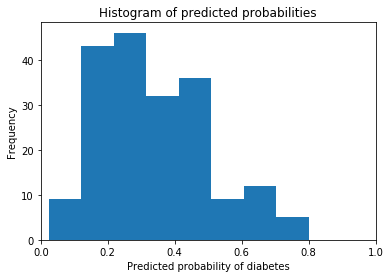

In [28]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

**Decrease the threshold** for predicting diabetes in order to **increase the sensitivity** of the classifier

In [29]:
# predict diabetes if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
y_pred_class = binarize([y_pred_prob], 0.3)[0]

In [30]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([0.36752429, 0.28356344, 0.28895886, 0.4141062 , 0.15896027,
       0.17065156, 0.49889026, 0.51341541, 0.27678612, 0.67189438])

In [31]:
# print the first 10 predicted classes with the lower threshold
y_pred_class[0:10]

#now there are 5 1's instead of 3

array([1., 0., 0., 1., 0., 0., 1., 1., 0., 1.])

In [32]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[118  12]
 [ 47  15]]


In [33]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[80 50]
 [16 46]]


In [34]:
# sensitivity has increased (used to be 0.24)
print(46 / float(46 + 16))

0.7419354838709677


In [35]:
# specificity has decreased (used to be 0.91)
print(80 / float(80 + 50))

0.6153846153846154


**Conclusion:**

- **Threshold of 0.5** is used by default (for binary problems) to convert predicted probabilities into class predictions
- Threshold can be **adjusted** to increase sensitivity or specificity
- Sensitivity and specificity have an **inverse relationship**

## ROC Curves and Area Under the Curve (AUC)

**Question:** Wouldn't it be nice if we could see how sensitivity and specificity are affected by various thresholds, without actually changing the threshold?

**Answer:** Plot the ROC curve!

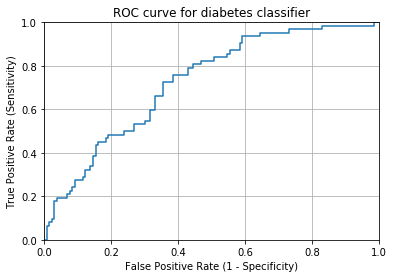

In [36]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# want false positve rate to be as small as possible with true positive rate as high as possible

- ROC curve can help you to **choose a threshold** that balances sensitivity and specificity in a way that makes sense for your particular context
- You can't actually **see the thresholds** used to generate the curve on the ROC curve itself

In [37]:
# define a function that accepts a threshold and prints sensitivity and specificity
def evaluate_threshold(threshold):
    print('Sensitivity:', tpr[thresholds > threshold][-1])
    print('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [38]:
evaluate_threshold(0.5)

Sensitivity: 0.24193548387096775
Specificity: 0.9076923076923077


In [39]:
evaluate_threshold(0.3)

Sensitivity: 0.7258064516129032
Specificity: 0.6153846153846154


AUC is the **percentage** of the ROC plot that is **underneath the curve**:

In [40]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities
print(metrics.roc_auc_score(y_test, y_pred_prob))

0.7245657568238213


- AUC is useful as a **single number summary** of classifier performance.
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a **higher predicted probability** to the positive observation.
- AUC is useful even when there is **high class imbalance** (unlike classification accuracy).

In [41]:
# calculate cross-validated AUC
from sklearn.model_selection import cross_val_score
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.7378233618233618

**Confusion matrix advantages:**

- Allows you to calculate a **variety of metrics**
- Useful for **multi-class problems** (more than two response classes)

**ROC/AUC advantages:**

- Does not require you to **set a classification threshold**
- Still useful when there is **high class imbalance**

## Exercise

Use knn or logistic regression to predict whether breast cancer is malignant or benign
1. Split data to training and testing
2. Optionally: Find the best parameter for knn using cross-validation on training data
3. Print the confusion matrix
4. Find classification accuracy, precision, recall, specificity, false positive rate
5. Plot ROC and find AUC

In [44]:
# Load breast cancer dataset sklearn.datasets.load_breast_cancer
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

In [45]:
# Make your own training, testing data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [ ]:
# Optionally investigate your data


In [48]:
# Optionally search for an optimal value of K for KNN use X_train as your dataset for cross validation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

# Plot the knn accuracy
import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')

ValueError: Found input variables with inconsistent numbers of samples: [426, 569]

In [52]:
# Train your classification model on the whole data and predict on the test
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=100, multi_class='auto', solver='liblinear')
logreg.fit(X_train, y_train)

y_pred_class = logreg.predict(X_test)

In [55]:
# Print the confusion matrix 
print(metrics.confusion_matrix(y_test, y_pred_class))

[[52  1]
 [ 5 85]]


In [54]:
# Classification accuracy
print(metrics.accuracy_score(y_test, y_pred_class))

0.958041958041958


In [56]:
# Sensitivity/Recall
print(metrics.recall_score(y_test, y_pred_class))

0.9444444444444444


In [57]:
# Specificity
confusion = metrics.confusion_matrix(y_test, y_pred_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

print(TN / float(TN + FP))

0.9811320754716981


In [58]:
# False Positive Rate
print(FP / float(TN + FP))

0.018867924528301886


In [59]:
# Precision
print(TP / float(TP + FP))
print(metrics.precision_score(y_test, y_pred_class))

0.9883720930232558
0.9883720930232558


In [ ]:
# Classification accuracy

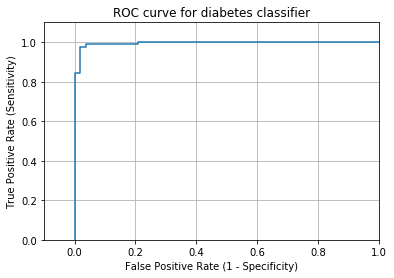

In [64]:
# Enter the calculation necessary for the ROC curve
y_pred_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.0])
plt.ylim([0.0, 1.1])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [65]:
# print AUC
print(metrics.roc_auc_score(y_test,y_pred_prob))

0.9947589098532496


In [66]:
# calculate AUC of cross-validation
cross_val_score(logreg, X, y, cv=10, scoring='roc_auc').mean()

0.9936241668384526